In [1]:
from ultralytics import YOLO


model = YOLO(model="yolo11n.pt")
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [2]:
import ast
import httpx
import cv2
from urllib.parse import urlparse
import base64

import numpy as np
import matplotlib.pyplot as plt


def read_image(path_or_url):
    """
    Reads an image from a file or a URL using OpenCV.

    Args:
        path_or_url (str): The file path or URL of the image.

    Returns:
        numpy.ndarray: The loaded image as a NumPy array.
    """
    try:
        # Check if input is a URL
        parsed = urlparse(path_or_url)
        if parsed.scheme in ("http", "https"):
            # Read image from URL
            with httpx.stream("GET", path_or_url, timeout=10) as response:
                if response.status_code == 200:
                    # Read the response content as bytes
                    image_array = np.asarray(bytearray(response.read()), dtype="uint8")
                    # Decode the image using OpenCV
                    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
                    if image is None:
                        raise ValueError("Failed to decode image from URL.")
                    return image
                else:
                    raise ValueError(
                        f"Failed to fetch image from URL: {response.status_code}"
                    )
        else:
            # Read image from local file
            image = cv2.imread(path_or_url, cv2.IMREAD_COLOR)
            if image is None:
                raise ValueError("Failed to read image from the file path.")
            return image
    except Exception as e:
        print(f"Error: {e}")
        return None


def image_to_base64(image):
    """
    Encodes an image to a Base64 string.

    Args:
        image_path (str): The file path of the image.

    Returns:
        str: The Base64-encoded string of the image.
    """
    try:
        # Read the image file
        # Encode the image as a binary buffer
        _, buffer = cv2.imencode(".jpg", image)

        # Convert the binary buffer to a Base64 string
        base64_string = base64.b64encode(buffer).decode("utf-8")

        return base64_string
    except Exception as e:
        print(f"Error: {e}")
        return None


def drawing(
    image,
    bbox,
    landmarks,
    caption=None,
    bbox_color=(0, 255, 0),
    landmark_color=(0, 0, 255),
    text_color=(0, 0, 0),
    thickness=2,
    radius=3,
    font_scale=0.5,
):
    """
    Draws a bounding box, landmarks, and an optional caption on an image.

    Args:
        image (numpy.ndarray): The image on which to draw.
        bbox (tuple): Bounding box as (x, y, w, h).
        landmarks (list of tuples): List of (x, y) coordinates for the landmarks.
        caption (str): Optional text to display above the bounding box.
        bbox_color (tuple): Color of the bounding box in BGR (default: green).
        landmark_color (tuple): Color of the landmarks in BGR (default: red).
        text_color (tuple): Color of the caption text in BGR (default: white).
        thickness (int): Thickness of the bounding box lines.
        radius (int): Radius of the landmarks.
        font_scale (float): Font scale for the caption text.

    Returns:
        numpy.ndarray: The image with the bounding box, landmarks, and caption drawn.
    """
    # Draw the bounding box
    x, y, w, h = bbox
    cv2.rectangle(image, (x, y), (x + w, y + h), bbox_color, thickness)

    # Draw the landmarks
    for landmark in landmarks:
        lx, ly = landmark
        cv2.circle(image, (int(lx), int(ly)), radius, landmark_color, -1)

    # Draw the caption above the bounding box
    if caption:
        # Calculate text size
        (text_width, text_height), _ = cv2.getTextSize(
            caption, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1
        )
        # Background rectangle for the caption
        cv2.rectangle(
            image, (x, y - text_height - 10), (x + text_width, y), bbox_color, -1
        )
        # Add text on top of the rectangle
        cv2.putText(
            image,
            caption,
            (x, y - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            text_color,
            1,
            lineType=cv2.LINE_AA,
        )

    return image


def xyxy_to_xywh(xyxy):
    """
    Converts a bounding box from (x_min, y_min, x_max, y_max) format to (x, y, width, height) format.

    Args:
        xyxy (tuple): A tuple (x_min, y_min, x_max, y_max).

    Returns:
        tuple: A tuple (x, y, width, height).
    """
    x_min, y_min, x_max, y_max = xyxy
    width = x_max - x_min
    height = y_max - y_min
    return (x_min, y_min, width, height)

In [3]:
model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

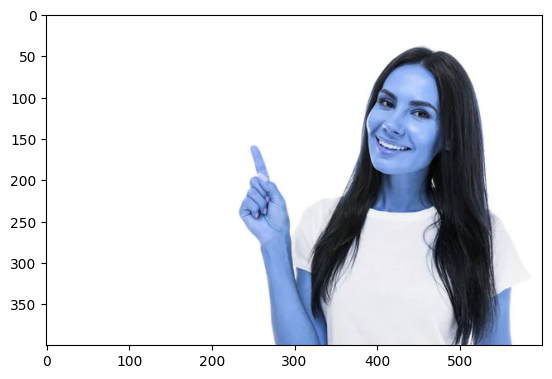

In [4]:
import ast
import httpx
import cv2
from urllib.parse import urlparse
import base64

import numpy as np

image_path = "./examples/test_01.jpg"
image = read_image(image_path)
plt.imshow(image)

In [5]:
model_resp = model.predict(image, classes=0)
person_bbox = model_resp[0].boxes.data.cpu().numpy()  # [[x1, y1, x2, y2, conf, cls_id]]

person_bbox[:, :5]


0: 448x640 1 person, 73.6ms
Speed: 3.3ms preprocess, 73.6ms inference, 159.0ms postprocess per image at shape (1, 3, 448, 640)


array([[     232.03,      38.181,      588.65,      395.45,     0.93941]], dtype=float32)

In [6]:
from boxmot import OcSort

tracker = OcSort()

track_resp = tracker.update(person_bbox[:, :6], image)
track_resp

array([[     232.03,      38.181,      588.65,      395.45,           1,     0.93941,           0,           0]])

In [7]:
data = {
    "images": {},
    "threshold": 0.6,
    "extract_ga": True,
    "extract_embedding": True,
    "return_face_data": False,
    "return_landmarks": True,
    "embed_only": False,
    "limit_faces": 0,
    "detect_masks": True,
    "msgpack": False,
}


def get_insight(
    frame, url: str = "http://0.0.0.0:18080/extract", is_pretty: bool = True
):
    data["images"] = {"data": [image_to_base64(frame)]}
    isf_resp = httpx.post(url=url, json=data)
    rsp = isf_resp.json()
    if is_pretty:
        rsp = rsp.get("data")[0]
        rsp = rsp.get("faces")
        if rsp == []:
            return []  # There is not worth of reading no faces
    return rsp

In [8]:
get_insight(frame=image)[0]

{'bbox': [387, 61, 481, 193],
 'landmarks': [[409, 106], [451, 122], [417, 141], [396, 146], [439, 161]],
 'prob': 0.8393247127532959,
 'num_det': 0,
 'scale': 1.0666666666666667,
 'norm': 22.410886764526367,
 'vec': [0.06383722275495529,
  -0.03834827244281769,
  -0.0029553421773016453,
  -0.07507271319627762,
  0.033879492431879044,
  0.022074351087212563,
  -0.07954444736242294,
  0.05062513053417206,
  -0.03964865580201149,
  -0.017774229869246483,
  0.009225528687238693,
  -0.0024683335795998573,
  0.043572597205638885,
  0.01241761352866888,
  0.040333446115255356,
  0.027050860226154327,
  -0.035155367106199265,
  -0.012755155563354492,
  -0.07093080133199692,
  -0.07475661486387253,
  0.037692002952098846,
  -0.014897787943482399,
  0.04683837667107582,
  0.008581092581152916,
  -0.06580931693315506,
  -0.1346740424633026,
  0.03067312389612198,
  0.007039476651698351,
  0.015102127566933632,
  0.053509779274463654,
  -0.037696465849876404,
  -0.02448013797402382,
  -0.03838957

In [9]:
# import tempfile
# from pytubefix import YouTube


# yt = YouTube(url="https://www.youtube.com/watch?v=Szt_kHWKwNo")
# yt_mp4 = yt.streams.filter(file_extension='mp4')
# yt_video = yt.streams.get_by_itag(18)
# yt_video.download(output_path='./examples')

In [10]:
def crop_image_by_bbox(image, bbox):
    """
    Crops an image using a bounding box in (x_min, y_min, x_max, y_max) format.
    Ensures the bounding box coordinates are integers.

    Args:
        image (numpy.ndarray): The input image as a NumPy array.
        bbox (tuple): The bounding box as (x_min, y_min, x_max, y_max).

    Returns:
        numpy.ndarray: The cropped image.
    """
    # Convert bounding box to integers
    x_min, y_min, x_max, y_max = map(int, bbox)

    # Ensure the coordinates are within the image boundaries
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(image.shape[1], x_max)
    y_max = min(image.shape[0], y_max)

    # Crop the image
    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image


def draw_bounding_box(
    image,
    bbox,
    caption=None,
    bbox_color=(0, 255, 0),
    text_color=(0, 0, 0),
    thickness=2,
    font_scale=0.5,
):
    # Draw the bounding box
    x, y, w, h = map(int, bbox)
    cv2.rectangle(image, (x, y), (x + w, y + h), bbox_color, thickness)

    # Draw the caption above the bounding box
    if caption:
        # Calculate text size
        (text_width, text_height), _ = cv2.getTextSize(
            caption, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1
        )
        # Background rectangle for the caption
        cv2.rectangle(
            image, (x, y - text_height - 10), (x + text_width, y), bbox_color, -1
        )
        # Add text on top of the rectangle
        cv2.putText(
            image,
            caption,
            (x, y - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            text_color,
            1,
            lineType=cv2.LINE_AA,
        )

    return image


def draw_landmarks(image, landmarks, color=(0, 0, 255), radius=2):
    """Draws landmarks on the frame."""
    for landmark in landmarks:
        x, y = landmark
        cv2.circle(image, (int(x), int(y)), radius, color, -1)
    return image


def adjust_bbox(person_bbox, face_bbox):
    """
    Aligns the face bounding box (box2) with the person bounding box (box1)
    by shifting it to the center of the person bounding box.

    Args:
        person_bbox (list): Original person bounding box (x1, y1, x2, y2).
        face_bbox (list): Original face bounding box (x1, y1, x2, y2).

    Returns:
        list: Adjusted face bounding box (x1, y1, x2, y2).
    """

    # Calculate center of person bounding box
    person_center_x = (person_bbox[0] + person_bbox[2]) / 2
    person_center_y = (person_bbox[1] + person_bbox[3]) / 2

    # Calculate center of face bounding box
    face_center_x = (face_bbox[0] + face_bbox[2]) / 2
    face_center_y = (face_bbox[1] + face_bbox[3]) / 2

    # Calculate shift amounts
    x_shift = person_center_x - face_center_x
    y_shift = person_center_y - face_center_y

    # Shift face bounding box coordinates
    aligned_face_bbox = [
        face_bbox[0] + x_shift,
        face_bbox[1] + y_shift,
        face_bbox[2] + x_shift,
        face_bbox[3] + y_shift,
    ]

    return aligned_face_bbox


def adjust_landmarks(landmarks, face_bbox):
    """
    Adjusts landmark coordinates based on the face bounding box.

    Args:
        landmarks (list): List of landmark coordinates (x, y).
        face_bbox (list): Face bounding box (x1, y1, x2, y2).

    Returns:
        list: Adjusted landmark coordinates.
    """
    face_width = face_bbox[2] - face_bbox[0]
    face_height = face_bbox[3] - face_bbox[1]

    adjusted_landmarks = []
    for x, y in landmarks:
        # Normalize landmark coordinates to [0, 1] range within the face bbox
        normalized_x = (x - face_bbox[0]) / face_width
        normalized_y = (y - face_bbox[1]) / face_height

        # Adjust landmarks based on the new face bbox position (assuming aligned)
        adjusted_x = normalized_x * face_width + face_bbox[0]
        adjusted_y = normalized_y * face_height + face_bbox[1]

        adjusted_landmarks.append((adjusted_x, adjusted_y))

    return adjusted_landmarks

In [11]:
import time

video_path = "./examples/face_detection.mp4"

cap = cv2.VideoCapture(video_path)
detect_person_rate = 0.75

start_time = time.time()
frame_end = 10
current_frame = 0
track_counter = {}

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # Detect a person
    model_resp = model.predict(frame, classes=0, conf=detect_person_rate, verbose=False)
    person_bboxes = (
        model_resp[0].boxes.data.cpu().numpy()
    )  # => [[x1, y1, x2, y2, conf, cls_idx]]

    if len(person_bboxes) == 0:
        person_bboxes = np.empty((0, 6))
    else:
        # Convert bounding box coordinates to integers
        person_bboxes[:, :4] = person_bboxes[:, :4].astype(int)

    # Track a person
    track_resp = tracker.update(
        person_bboxes, frame
    )  # => [[x1, y1, x2, y2, track_idx, conf, cls_idx, 0]]

    # Detect a face and draw bounding box and landmarks
    if len(track_resp) != 0:
        for resp in track_resp:
            person_frame = crop_image_by_bbox(frame, resp[:4])

            ins_face_data = get_insight(person_frame)
            if ins_face_data != []:
                ins_face_data = ins_face_data[0]  # 1 face per person

                # Draw bounding box
                bbox = ins_face_data.get("bbox")
                bbox = adjust_bbox(resp[:4], bbox)
                frame = draw_bounding_box(frame, xyxy_to_xywh(bbox))

                # Draw landmarks (if available)
                landmarks = ins_face_data.get("landmarks")
                landmarks = adjust_landmarks(landmarks, bbox)
                # Create caption (optional)
                caption = f"Track's id: {resp[5]}\nFace Detection Rate: {str(ins_face_data.get('prob'))}\n"

                track_counter[resp[5]] = (bbox, landmarks, caption)

    # Display frame with bounding boxes and landmarks (if drawn)
    cv2.imshow("Tracking Person and Get Face Info", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

print(f"Total cost: {time.time() - start_time}")

Total cost: 358.5096535682678


# Mult-threading

In [13]:
import time
import cv2
import numpy as np
from queue import Queue
import threading

video_path = "./examples/face_detection.mp4"
detect_person_rate = 0.75


def process_frame(frame, queue):
    """Processes a single frame, detecting people, faces, and adjusting bounding boxes and landmarks."""

    # Detect a person
    model_resp = model.predict(frame, classes=0, conf=detect_person_rate, verbose=False)
    person_bboxes = (
        model_resp[0].boxes.data.cpu().numpy()
    )  # => [[x1, y1, x2, y2, conf, cls_idx]]

    if len(person_bboxes) == 0:
        person_bboxes = np.empty((0, 6))
    else:
        # Convert bounding box coordinates to integers
        person_bboxes[:, :4] = person_bboxes[:, :4].astype(int)

    # Track a person
    track_resp = tracker.update(
        person_bboxes, frame
    )  # => [[x1, y1, x2, y2, track_idx, conf, cls_idx, 0]]

    # Detect a face and draw bounding box and landmarks
    if len(track_resp) != 0:
        track_counter = {}  # Local track_counter for each frame (avoids race conditions)
        for resp in track_resp:
            person_frame = crop_image_by_bbox(frame, resp[:4])

            ins_face_data = get_insight(person_frame)
            if ins_face_data != []:
                ins_face_data = ins_face_data[0]  # 1 face per person

                # Adjust bounding box
                bbox = ins_face_data.get("bbox")
                adjusted_bbox = adjust_bbox(resp[:4], bbox)

                # Adjust landmarks
                landmarks = ins_face_data.get("landmarks")
                adjusted_landmarks = adjust_landmarks(landmarks, adjusted_bbox)

                # Create caption (optional)
                caption = f"Track's id: {resp[5]}\nFace Detection Rate: {str(ins_face_data.get('prob'))}\n"

                track_counter[resp[5]] = (adjusted_bbox, adjusted_landmarks, caption)

        queue.put(track_counter)  # Add track_counter to queue for display


def display_results(queue):
    """Displays frames with bounding boxes and landmarks."""
    while True:
        track_counter = queue.get()  # Wait for processed frame data

        frame = track_counter.popitem()[
            0
        ]  # Extract frame from track_counter (assuming first item)
        for bbox, landmarks, caption in track_counter.values():
            frame = draw_bounding_box(frame, xyxy_to_xywh(bbox))
            frame = draw_landmarks(frame, landmarks)

        # Display frame
        cv2.imshow("Tracking Person and Get Face Info", frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

        queue.task_done()  # Signal task completion for queue management


"""Main function for video processing."""
start_time = time.time()

cap = cv2.VideoCapture(video_path)

# Create queues for frame processing and display
frame_queue = Queue()
display_queue = Queue()

# Create threads
processing_thread = threading.Thread(
    target=process_frame, args=(cap.read()[1], frame_queue)
)
display_thread = threading.Thread(target=display_results, args=(display_queue,))

# Start threads
processing_thread.start()
display_thread.start()

while cap.isOpened():
    # Read next frame (non-blocking)
    success, frame = cap.read()

    # Add frame to processing queue
    frame_queue.put(frame.copy())  # Avoid modifying original frame

    # Wait for processing thread to finish
    frame_queue.join()

    # Signal display thread to stop (optional, might be redundant)
    display_queue.put(None)

print(f"Total cost: {time.time() - start_time}")

KeyboardInterrupt: 

In [15]:
import time
import cv2
import numpy as np
from queue import Queue
import threading

video_path = "./examples/face_detection.mp4"
detect_person_rate = 0.75

start_time = time.time()


# Create queues for inter-thread communication
frame_queue = Queue()
detection_queue = Queue()
tracking_queue = Queue()
display_queue = Queue()


def read_frames(cap, frame_queue):
    """Reads frames from the video and puts them into the frame queue."""
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        frame_queue.put(frame.copy())  # Avoid modifying original frame


def detect_people(frame_queue, detection_queue):
    """Detects people in frames and puts results into the detection queue."""
    while True:
        frame = frame_queue.get()
        if frame is None:
            break

        model_resp = model.predict(
            frame, classes=0, conf=detect_person_rate, verbose=False
        )
        person_bboxes = (
            model_resp[0].boxes.data.cpu().numpy()
        )  # => [[x1, y1, x2, y2, conf, cls_idx]]

        if len(person_bboxes) == 0:
            person_bboxes = np.empty((0, 6))
        else:
            person_bboxes[:, :4] = person_bboxes[:, :4].astype(int)

        detection_queue.put((frame, person_bboxes))
        frame_queue.task_done()


def track_objects(detection_queue, tracking_queue):
    """Tracks objects in frames and puts tracking results into the tracking queue."""
    while True:
        frame, person_bboxes = detection_queue.get()
        if frame is None:
            break

        track_resp = tracker.update(
            person_bboxes, frame
        )  # => [[x1, y1, x2, y2, track_idx, conf, cls_idx, 0]]
        tracking_queue.put((frame, track_resp))
        detection_queue.task_done()


def detect_faces(tracking_queue, display_queue):
    """Detects faces in frames and puts results (with bounding boxes and landmarks) into the display queue."""
    while True:
        frame, track_resp = tracking_queue.get()
        if frame is None:
            break

        frame_with_results = frame.copy()  # Avoid modifying original frame
        track_counter = {}

        if len(track_resp) != 0:
            for resp in track_resp:
                person_frame = crop_image_by_bbox(frame, resp[:4])
                ins_face_data = get_insight(person_frame)
                if ins_face_data != []:
                    ins_face_data = ins_face_data[0]  # 1 face per person

                    # Adjust bounding box
                    bbox = ins_face_data.get("bbox")
                    adjusted_bbox = adjust_bbox(resp[:4], bbox)

                    # Adjust landmarks
                    landmarks = ins_face_data.get("landmarks")
                    adjusted_landmarks = adjust_landmarks(landmarks, adjusted_bbox)

                    # Create caption (optional)
                    caption = f"Track's id: {resp[5]}\nFace Detection Rate: {str(ins_face_data.get('prob'))}\n"

                    track_counter[resp[5]] = (
                        adjusted_bbox,
                        adjusted_landmarks,
                        caption,
                    )

        # Draw results on the frame
        for bbox, landmarks, caption in track_counter.values():
            frame_with_results = draw_bounding_box(
                frame_with_results, xyxy_to_xywh(bbox)
            )
            frame_with_results = draw_landmarks(frame_with_results, landmarks)

        display_queue.put(frame_with_results)
        tracking_queue.task_done()


def display_video(display_queue):
    """Displays the processed frames with results."""
    while True:
        frame = display_queue.get()
        if frame is None:
            break

        cv2.imshow("Tracking Person and Get Face Info", frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

        display_queue.task_done()


if __name__ == "__main__":
    start_time = time.time()

    cap = cv2.VideoCapture(video_path)

    # Create and start threads
    read_thread = threading.Thread(target=read_frames, args=(cap, frame_queue))
    detection_thread = threading.Thread(
        target=detect_people, args=(frame_queue, detection_queue)
    )
    tracking_thread = threading.Thread(
        target=track_objects, args=(detection_queue, tracking_queue)
    )
    face_detection_thread = threading.Thread(
        target=detect_faces, args=(tracking_queue, display_queue)
    )
    display_thread = threading.Thread(target=display_video, args=(display_queue,))

    read_thread.start()
    detection_thread.start()
    tracking_thread.start()
    face_detection_thread.start()
    display_thread.start()

    # Wait for all threads to finish
    read_thread.join()
    detection_thread.join()
    tracking_thread.join()
    face_detection_thread.join()
    display_thread.join()

    cap.release()
    cv2.destroyAllWindows()

    print(f"Total cost: {time.time() - start_time}")

KeyboardInterrupt: 